# Assignment

1.  Try a real corpus (instead of banana apple, try something real... on the internet....) - not so big!  Just so you have a good taste of real stuff....like 50 documents, each having 50 words...(really up to you)

2. Try a window size of 2

3. Implement CBOW (instead of skipgrams)

4. Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
import pandas as pd

# Read the CSV file which contain spotify song lyric 
df = pd.read_csv("C:\\Users\\ASUS\\My_Journal\\Text\\My-NLP\\spotify_millsongdata.csv")

# Randomly select 50 song
sample = df.sample(30)

# Print the sample
print(sample)

                      artist                                         song  \
20544           Van Morrison                                 Chick-A-Boom   
44508            Moody Blues                                    The Voice   
23913                America                                     Survival   
56402                    Who                               The Acid Queen   
27222            Cheap Trick                                     O Claire   
31851            Erik Santos                              It Might Be You   
18000         Rolling Stones                         Down The Road Apiece   
51996                Squeeze                                Remember What   
45207                  Ne-Yo                                 Start A Fire   
39332              Kari Jobe                                         Here   
6771           George Strait       Looking Out My Window Through The Pain   
28523           Cyndi Lauper                          Give Peace A Chance   

In [3]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 20544 to 37157
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  50 non-null     object
 1   song    50 non-null     object
 2   link    50 non-null     object
 3   text    50 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


In [4]:
corpus = sample["text"].replace(r"\\|\r|\n|", "").tolist()

import spacy
nlp = spacy.load("en_core_web_sm")
corpus_tokenized = [nlp(sent) for sent in corpus]
corpus_tokenized

[(Shut that door)  
   
 (Cross the floor) ha-ha  
   
 Hey, girl!  
 When ya swish and sway  
 In your yellow dress  
 'Cross the crowded room  
 Boom, chicka-boom, chicka-boom  
   
 Hey, girl!  
 Freckles on your arms  
 Freckles on your face  
 Can't we find a place?  
 In a crowded room, we go  
   
 Boom, chicka-boom, chicka-boom  
 (Chicka-boom, chicka-boom)  
 Boom (chicka-boom, chicka-boom-boom)  
 Boom, chicka-boom, chicka-boom  
 (Chicka-chicka-chicka-boom)  
   
 A-hey, girl!  
 I'm goin' away  
 But I'm comin' back  
 With a ginger cat  
 What'd ya think a-that?  
   
 Hey, girl!  
 I'm goin' away  
 But I'm comin' back  
 By the railroad track  
   
 Where the trains go by  
 And we sang and cry in gloom  
 Boom, chicka-boom  
 (Chicka-boom, chicka-boom)  
   
 Hey, girl!  
 (Chicka-boom, chick-a boom-boom)  
 When ya swish and sway  
 (Chicka, chicka, chicka-boom)  
 In your yellow dress  
 'Cross the crowded room, boom  
   
 Boom, chicka-boom, chicka-boom  
 (Chicka-bo

In [5]:
# convert scapy token to str
corpus_tokenized = [[str(word) for word in sublist] for sublist in corpus_tokenized]
corpus_tokenized


[['(',
  'Shut',
  'that',
  'door',
  ')',
  ' \r\n  \r\n',
  '(',
  'Cross',
  'the',
  'floor',
  ')',
  'ha',
  '-',
  'ha',
  ' \r\n  \r\n',
  'Hey',
  ',',
  'girl',
  '!',
  ' \r\n',
  'When',
  'ya',
  'swish',
  'and',
  'sway',
  ' \r\n',
  'In',
  'your',
  'yellow',
  'dress',
  ' \r\n',
  "'",
  'Cross',
  'the',
  'crowded',
  'room',
  ' \r\n',
  'Boom',
  ',',
  'chicka',
  '-',
  'boom',
  ',',
  'chicka',
  '-',
  'boom',
  ' \r\n  \r\n',
  'Hey',
  ',',
  'girl',
  '!',
  ' \r\n',
  'Freckles',
  'on',
  'your',
  'arms',
  ' \r\n',
  'Freckles',
  'on',
  'your',
  'face',
  ' \r\n',
  'Ca',
  "n't",
  'we',
  'find',
  'a',
  'place',
  '?',
  ' \r\n',
  'In',
  'a',
  'crowded',
  'room',
  ',',
  'we',
  'go',
  ' \r\n  \r\n',
  'Boom',
  ',',
  'chicka',
  '-',
  'boom',
  ',',
  'chicka',
  '-',
  'boom',
  ' \r\n',
  '(',
  'Chicka',
  '-',
  'boom',
  ',',
  'chicka',
  '-',
  'boom',
  ')',
  ' \r\n',
  'Boom',
  '(',
  'chicka',
  '-',
  'boom',
  ',',
  'c

In [6]:
#2. numericalize

#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]

vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

#add <UNK>, which is a very normal token exists in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything

#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = len(word2index)  #usually <UNK> is 0

#create index2word dictionary
#2 min    
index2word = {v:k for k, v in word2index.items()}


In [7]:
print(word2index)

{'Sometimes': 0, 'Put': 1, 'devil': 2, 'angel': 3, 'Hip': 4, 'Vomit': 5, 'fight': 6, 'Drawn': 7, 'Cherished': 8, 'corpse': 9, 'care': 10, 'rotting': 11, 'Pe': 12, 'reveille': 13, 'small': 14, 'Ruby': 15, 'That': 16, 'form': 17, 'mother': 18, 'hell': 19, 'prayer': 20, 'live': 21, 'to': 22, 'rests': 23, 'radio': 24, 'hurt': 25, 'Tell': 26, 'devotion': 27, 'world': 28, 'come': 29, 'kids': 30, 'burdens': 31, 'mothers': 32, 'heal': 33, 'movie': 34, 'curled': 35, 'counting': 36, 'coming': 37, 'confusion': 38, 'guaranteed': 39, 'me': 40, 'she': 41, 'You': 42, 'Can': 43, 'Ran': 44, '\r\n\r\n': 45, 'sorry': 46, 'scared': 47, 'chance': 48, 'pace': 49, 'slide': 50, 'blue': 51, 'do': 52, 'any': 53, 'smoked': 54, 'Night': 55, 'Spector': 56, 'why': 57, 'Does': 58, 'Danger': 59, 'solution': 60, 'hero': 61, 'seen': 62, 'country': 63, "'d": 64, 'held': 65, 'desire': 66, 'Lead': 67, 'place': 68, 'rollers': 69, 'song': 70, 'drink': 71, 'final': 72, 'Dressed': 73, 'Vietnam': 74, 'Zealand': 75, ' \r\n  \r\

## 2. Prepare train data
You move the window along, and create those tuples as we said in class

In [8]:
window_size=2
cbows = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(window_size,len(sent)-window_size):# start from window_size end at window_size before last
        center_word = word2index[sent[i]]
        # outside words
        outside_words = [word2index[sent[j]] for j in range(max(0, i - window_size), min(len(sent), i + window_size + 1)) if j != i]
        for o in outside_words:
            cbows.append([o, center_word])

cbows

[[944, 469],
 [1173, 469],
 [648, 469],
 [173, 469],
 [1173, 648],
 [469, 648],
 [173, 648],
 [76, 648],
 [469, 173],
 [648, 173],
 [76, 173],
 [944, 173],
 [648, 76],
 [173, 76],
 [944, 76],
 [1046, 76],
 [173, 944],
 [76, 944],
 [1046, 944],
 [1682, 944],
 [76, 1046],
 [944, 1046],
 [1682, 1046],
 [729, 1046],
 [944, 1682],
 [1046, 1682],
 [729, 1682],
 [173, 1682],
 [1046, 729],
 [1682, 729],
 [173, 729],
 [881, 729],
 [1682, 173],
 [729, 173],
 [881, 173],
 [622, 173],
 [729, 881],
 [173, 881],
 [622, 881],
 [881, 881],
 [173, 622],
 [881, 622],
 [881, 622],
 [76, 622],
 [881, 881],
 [622, 881],
 [76, 881],
 [1191, 881],
 [622, 76],
 [881, 76],
 [1191, 76],
 [1189, 76],
 [881, 1191],
 [76, 1191],
 [1189, 1191],
 [1076, 1191],
 [76, 1189],
 [1191, 1189],
 [1076, 1189],
 [847, 1189],
 [1191, 1076],
 [1189, 1076],
 [847, 1076],
 [1099, 1076],
 [1189, 847],
 [1076, 847],
 [1099, 847],
 [241, 847],
 [1076, 1099],
 [847, 1099],
 [241, 1099],
 [1216, 1099],
 [847, 241],
 [1099, 241],
 [12

In [9]:
corpus_tokenized

[['(',
  'Shut',
  'that',
  'door',
  ')',
  ' \r\n  \r\n',
  '(',
  'Cross',
  'the',
  'floor',
  ')',
  'ha',
  '-',
  'ha',
  ' \r\n  \r\n',
  'Hey',
  ',',
  'girl',
  '!',
  ' \r\n',
  'When',
  'ya',
  'swish',
  'and',
  'sway',
  ' \r\n',
  'In',
  'your',
  'yellow',
  'dress',
  ' \r\n',
  "'",
  'Cross',
  'the',
  'crowded',
  'room',
  ' \r\n',
  'Boom',
  ',',
  'chicka',
  '-',
  'boom',
  ',',
  'chicka',
  '-',
  'boom',
  ' \r\n  \r\n',
  'Hey',
  ',',
  'girl',
  '!',
  ' \r\n',
  'Freckles',
  'on',
  'your',
  'arms',
  ' \r\n',
  'Freckles',
  'on',
  'your',
  'face',
  ' \r\n',
  'Ca',
  "n't",
  'we',
  'find',
  'a',
  'place',
  '?',
  ' \r\n',
  'In',
  'a',
  'crowded',
  'room',
  ',',
  'we',
  'go',
  ' \r\n  \r\n',
  'Boom',
  ',',
  'chicka',
  '-',
  'boom',
  ',',
  'chicka',
  '-',
  'boom',
  ' \r\n',
  '(',
  'Chicka',
  '-',
  'boom',
  ',',
  'chicka',
  '-',
  'boom',
  ')',
  ' \r\n',
  'Boom',
  '(',
  'chicka',
  '-',
  'boom',
  ',',
  'c

In [10]:
def cbow_random_batch(batch_size, corpus, window_size=1):
    
    cbows = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        # # start from window_size end at window_size before last
        for i in range(window_size,len(sent)-window_size):
            center_word = word2index[sent[i]]
            # outside words 
            outside_words = [word2index[sent[j]] for j in range(max(0, i - window_size), min(len(sent), i + window_size + 1)) if j != i]
            for o in outside_words:
                # append outside word as input center word as output
                cbows.append([o, center_word])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(cbows)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([cbows[index][0]])  #outside words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([cbows[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)


In [11]:
batch_size = 10
input, label = cbow_random_batch(batch_size, corpus_tokenized, window_size=2)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[  91],
       [ 234],
       [ 821],
       [ 654],
       [1682],
       [1076],
       [1682],
       [ 669],
       [1071],
       [1264]])


## 3. Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [12]:
#basically create a distribution of all the words you have in your vocabs

In [13]:
z = 0.001  #scaling up low frequency terms

In [14]:
#count all the occurrences of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

Counter({'(': 50,
         'Shut': 1,
         'that': 80,
         'door': 6,
         ')': 49,
         ' \r\n  \r\n': 311,
         'Cross': 3,
         'the': 378,
         'floor': 2,
         'ha': 10,
         '-': 90,
         'Hey': 33,
         ',': 457,
         'girl': 13,
         '!': 9,
         ' \r\n': 1308,
         'When': 28,
         'ya': 4,
         'swish': 2,
         'and': 135,
         'sway': 2,
         'In': 20,
         'your': 97,
         'yellow': 2,
         'dress': 4,
         "'": 60,
         'crowded': 3,
         'room': 6,
         'Boom': 7,
         'chicka': 48,
         'boom': 62,
         'Freckles': 2,
         'on': 88,
         'arms': 9,
         'face': 12,
         'Ca': 2,
         "n't": 206,
         'we': 60,
         'find': 13,
         'a': 194,
         'place': 19,
         '?': 38,
         'go': 28,
         'Chicka': 24,
         'A': 6,
         'hey': 29,
         'I': 519,
         "'m": 97,
         "goin'": 2,
    

In [15]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

13419

In [16]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
Counter(unigram_table)

Counter({'devil': 1,
         'fight': 1,
         'corpse': 1,
         'care': 3,
         'rotting': 1,
         'small': 2,
         'Ruby': 3,
         'That': 5,
         'form': 2,
         'mother': 1,
         'hell': 1,
         'prayer': 1,
         'live': 3,
         'to': 52,
         'hurt': 1,
         'Tell': 2,
         'world': 6,
         'come': 8,
         'kids': 1,
         'mothers': 1,
         'counting': 1,
         'coming': 2,
         'me': 35,
         'she': 6,
         'You': 31,
         'Can': 2,
         '\r\n\r\n': 13,
         'sorry': 1,
         'chance': 3,
         'blue': 4,
         'do': 27,
         'any': 3,
         'why': 3,
         'Does': 1,
         'seen': 1,
         "'d": 6,
         'desire': 1,
         'Lead': 1,
         'place': 7,
         'song': 3,
         'drink': 2,
         ' \r\n  \r\n': 59,
         'child': 2,
         'got': 9,
         'wish': 1,
         'rosy': 3,
         'Chick': 1,
         'chasing': 1,
   

## 4. Negative sampling

A function to get negative samples, based on the current center and outside words in the batch

In [17]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [18]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

### Test our negative sampling method

In [19]:
batch_size = 2
input_batch, label_batch = cbow_random_batch(batch_size, corpus_tokenized)

input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

num_neg = 10  #in the real code, we gonna use 10 (like in the paper)
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)


In [20]:
neg_samples.shape

torch.Size([2, 10])

## 5. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [21]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()


### Testing the model

In [22]:
input, label = cbow_random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [23]:
emb_size = 2 #usually, this can be 50, 100, or 300
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [24]:
neg_tensor = negative_sampling(label_tensor, unigram_table,  num_neg)

In [25]:
input_tensor.shape, label_tensor.shape#, neg_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [26]:
#this should give one number
loss = model(input_tensor, label_tensor, neg_tensor)

In [27]:
loss

tensor(1.0375, grad_fn=<NegBackward0>)

## 4. Training

In [28]:
voc_size   = len(vocabs)
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time 

time.time()

1673762366.0090034

In [30]:

import time

num_epochs = 5000
#start time
start_time = time.time()
pre_time = start_time
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = cbow_random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        curr_time = time.time()
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {curr_time-pre_time:.2f} sec")
        pre_time = curr_time

print(f"total time : {curr_time-start_time:.2f}")

Epoch 1000 | Loss: 3.564858 | Time: 42.89 sec
Epoch 2000 | Loss: 1.294743 | Time: 40.91 sec
Epoch 3000 | Loss: 1.288277 | Time: 43.81 sec
Epoch 4000 | Loss: 0.123446 | Time: 42.05 sec
Epoch 5000 | Loss: 0.093437 | Time: 42.18 sec
total time : 211.84


## 5. Plot the embeddings

Is really the related stuff are close to each other, and vice versa?

The most fun part:  Will "banana" closer to "fruit" than "cat"?

In [31]:
vocabs

['Sometimes',
 'Put',
 'devil',
 'angel',
 'Hip',
 'Vomit',
 'fight',
 'Drawn',
 'Cherished',
 'corpse',
 'care',
 'rotting',
 'Pe',
 'reveille',
 'small',
 'Ruby',
 'That',
 'form',
 'mother',
 'hell',
 'prayer',
 'live',
 'to',
 'rests',
 'radio',
 'hurt',
 'Tell',
 'devotion',
 'world',
 'come',
 'kids',
 'burdens',
 'mothers',
 'heal',
 'movie',
 'curled',
 'counting',
 'coming',
 'confusion',
 'guaranteed',
 'me',
 'she',
 'You',
 'Can',
 'Ran',
 '\r\n\r\n',
 'sorry',
 'scared',
 'chance',
 'pace',
 'slide',
 'blue',
 'do',
 'any',
 'smoked',
 'Night',
 'Spector',
 'why',
 'Does',
 'Danger',
 'solution',
 'hero',
 'seen',
 'country',
 "'d",
 'held',
 'desire',
 'Lead',
 'place',
 'rollers',
 'song',
 'drink',
 'final',
 'Dressed',
 'Vietnam',
 'Zealand',
 ' \r\n  \r\n',
 'child',
 'Leave',
 'got',
 'wish',
 'rosy',
 'losin',
 'Chick',
 'chasing',
 'bags',
 'Oprah',
 'my',
 'maybe',
 'red',
 'Born',
 'from',
 'signs',
 'was',
 'two',
 'memories',
 'adrenaline',
 'Stuck',
 'on',
 'h

In [32]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


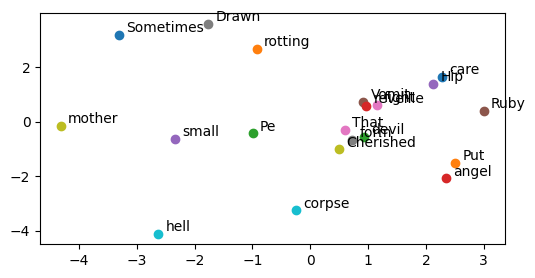

In [34]:
# plot matplotlib
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

How do (from scratch) calculate cosine similarity?

In [37]:
from numpy import dot
from numpy.linalg import norm

def cos_similarity(word1,word2):
    a = get_embed(word1)
    b = get_embed(word2)

    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return cos_sim

word1 = "devil"
word2 = "rainfall"
word3 = "angle"
print(f"{word1} {word2} similarity : {cos_similarity(word1,word2):.3f}")
print(f"{word3} {word2} similarity : {cos_similarity(word3,word2):.3f}")
print(f"{word1} {word3} similarity : {cos_similarity(word1,word3):.3f}")
    

devil rainfall similarity : -0.330
angle rainfall similarity : -0.827
devil angle similarity : 0.804
